# Gaussian Kernel Approximation with Structured Spherical Features

This Jupyter notebook demonstrates the concept of using Structured Spherical Features (SSF) to approximate the Gaussian kernel, as introduced in the seminal paper:

> Lyu, Y. (2017, July). Spherical structured feature maps for kernel approximation. In International Conference on Machine Learning (pp. 2256-2264). PMLR.

The Gaussian kernel is a popular choice in various machine learning applications, particularly because of its properties of smoothness and locality. The kernel function is defined as:

$$ k(\tau) = e^{-\frac{\|\tau\|^2}{2}} $$

where $ \tau $ is the difference between two points in the input space. The power spectrum of the Gaussian kernel, which is its Fourier transform, is also Gaussian:

$$ p(\omega) = (2\pi)^{-\frac{D}{2}} e^{-\frac{\|\omega\|^2}{2}} $$

where $ \omega $ represents frequency components and $ D $ is the dimensionality of the input space.

This notebook is prepared by Ryan Farell as a demonstration of the ssf technique, aiming to provide a hands-on understanding of the concept and its implementation.

## Credits
- **Original Paper Author**: Yueming Lyu
- **Notebook Creator**: Ryan Farell

# SSF

Energy: -186322.4531
Best energy: -186438.2969


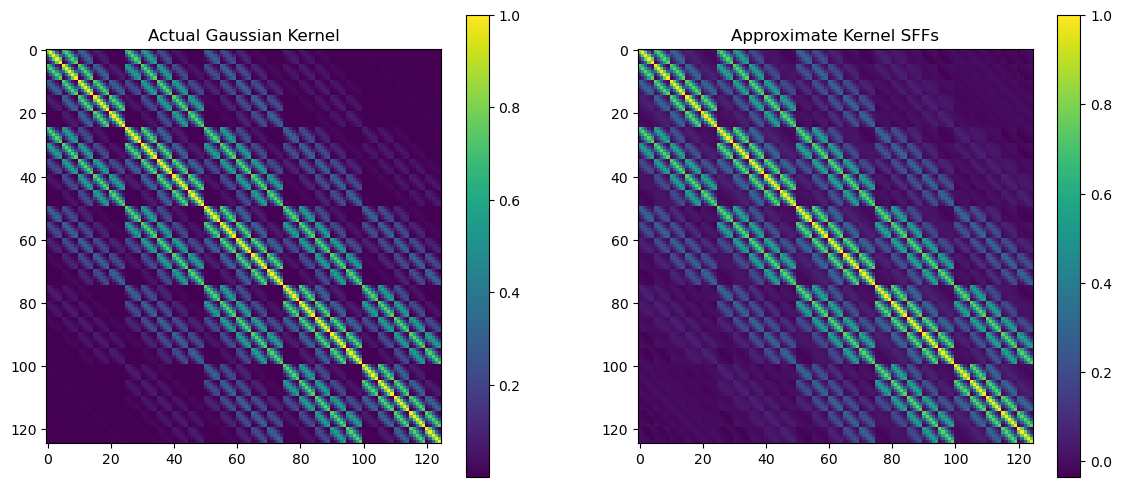

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import chi

# Define the Gaussian kernel function for 2-dimensional input
def gaussian_kernel_matrix(X, sigma=1):
    """
    Calculate the Gaussian kernel matrix for all pairs of data in X.

    Parameters:
    X (np.ndarray): A Nxm matrix where N is the number of data points and m is the number of dimensions.
    sigma (float): The standard deviation parameter of the Gaussian kernel.

    Returns:
    np.ndarray: An NxN matrix where the element at (i, j) represents the Gaussian kernel between X[i] and X[j].
    """
    # Calculate the squared Euclidean distance matrix
    diff = X[:, np.newaxis, :] - X[np.newaxis, :, :]
    sq_dist_matrix = np.sum(diff ** 2, axis=-1)

    # Calculate the Gaussian kernel matrix
    kernel_matrix = np.exp(-sq_dist_matrix / (2 * sigma ** 2))

    return kernel_matrix


def sample_r(M, df=2):
    uniform_samples = np.array([j/(M+1) for j in range(1, M+1)])

    # Transform these samples through the inverse CDF of the chi distribution
    chi_samples = chi.ppf(uniform_samples, df)

    return chi_samples.reshape(M, 1)

def riesz_energy(V):
    N = V.shape[0]
    diff = V.unsqueeze(1) - V.unsqueeze(0)
    dist = torch.norm(diff, p=2, dim=2)
    dist = dist + torch.eye(N, device=dist.device)  # Avoid division by zero
    energy = -torch.sum(torch.log(dist)) + N * torch.log(torch.tensor(N, dtype=dist.dtype, device=dist.device))
    return energy

def sample_v_pytorch(N, dimension):
    points = torch.randn(N, dimension)
    norms = torch.norm(points, dim=1, keepdim=True)
    v = points / norms
    return v

def sample_v(N, dimension):
    learning_rate = 0.001
    num_iterations = 100

    V = sample_v_pytorch(N, dimension)
    V = torch.nn.Parameter(V)

    # plt.figure(figsize=(6, 6))
    # if dimension == 2:  # Check for 2D
    #     plt.scatter(V[:, 0].detach().numpy(), V[:, 1].detach().numpy(), s=2)
    #     plt.title('Initial points on the sphere')
    #     plt.xlabel('x')
    #     plt.ylabel('y')
    #     plt.show()

    optimizer = torch.optim.Adam([V], lr=learning_rate)

    best_energy = float('inf')
    best_V = None
    for _ in range(num_iterations):
        optimizer.zero_grad()
        energy = riesz_energy(V)
        energy.backward()
        optimizer.step()

        with torch.no_grad():
            norms = torch.norm(V, dim=1, keepdim=True)
            V /= norms
        
        if energy < best_energy:
            best_energy = energy
            best_V = V.clone()
        if _ % 100 == 0:
            print('Energy: {:.4f}'.format(energy.item()))

    # if dimension == 2:  # Check for 2D
    #     plt.figure(figsize=(6, 6))
    #     plt.scatter(V[:, 0].detach().numpy(), V[:, 1].detach().numpy(), s=2)
    #     plt.title('Final points on the sphere')
    #     plt.xlabel('x')
    #     plt.ylabel('y')
    #     plt.show()

    print('Best energy: {:.4f}'.format(best_energy.item()))
    return best_V.detach().numpy()

def compute_z(X, r, v):
    """
    Compute the feature map Z in a vectorized manner.

    Parameters:
    X (np.ndarray): Input data points.
    r (np.ndarray): Radii sampled from a chi-squared distribution.
    v (np.ndarray): Points sampled from the unit sphere.

    Returns:
    np.ndarray: Computed feature map Z.
    """
    M, _ = r.shape
    N, _ = v.shape

    # Broadcasting Xv calculation for all points in v
    Xv = X @ v.T  # Shape: (len(X), N)

    # Use broadcasting to perform cos and sin operations efficiently
    # First, reshape r to be compatible for broadcasting
    r_reshaped = r.reshape(1, M, 1)  # Shape: (1, M, 1)
    Xv_reshaped = Xv[:, None, :]  # Shape: (len(X), 1, N)

    # Broadcasted operations
    cos_values = np.cos(r_reshaped * Xv_reshaped)  # Shape: (len(X), M, N)
    sin_values = np.sin(r_reshaped * Xv_reshaped)  # Shape: (len(X), M, N)

    # Reshape and concatenate the cos and sin values
    Z = np.concatenate([cos_values, sin_values], axis=-1).reshape(len(X), -1)

    return Z/np.sqrt(M*N)

# Compute the approximate kernel
def approximate_kernel(X, Y, r, v):
    Z_X = compute_z(X, r, v)
    Z_Y = compute_z(Y, r, v)
    kernel_matrix = Z_X @ Z_Y.T
    return kernel_matrix

# Plot the actual and approximate kernels
def plot_kernels(X, M, N, dimension):
    # Compute the actual kernel matrix
    actual_kernel = gaussian_kernel_matrix(X)

    # Sample r and v
    r = sample_r(M, df=dimension)
    v = sample_v(N, dimension)

    # Compute the approximate kernel matrix
    approx_kernel = approximate_kernel(X, X, r, v)

    # Plot the kernel matrices
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(actual_kernel)
    plt.colorbar()
    plt.title('Actual Gaussian Kernel')

    plt.subplot(1, 2, 2)
    plt.imshow(approx_kernel)
    plt.colorbar()
    plt.title('Approximate Kernel SFFs')
    plt.savefig('ssf_kernel_2d.png')

# Set parameters for 3D
dimension = 3
M = 50  # Assuming this is related to your kernel computation
N = 1000  # Assuming this is also related to your kernel computation
n_points = 5  # Number of points in each dimension

# Create 1D arrays for each dimension
x1 = np.linspace(0, 3, n_points)
x2 = np.linspace(0, 3, n_points)
x3 = np.linspace(0, 3, n_points)

# Create a 3D grid of points
X = np.array(np.meshgrid(x1, x2, x3)).T.reshape(-1, 3)

# Plot the kernels (assuming plot_kernels can handle 3D data)
plot_kernels(X, M, N, dimension)

## Convergence Analysis of Kernel Approximation Errors

In this section, we analyze the convergence of the total error and the worst-case error as the number of random features \( D \) increases. The total error is computed as the sum of absolute differences between the actual kernel and the approximate kernel across all pairs of points. Similarly, the worst-case error is determined by the maximum absolute difference between the two kernels for any pair of points.

As the plots below demonstrate, both the total error and the worst-case error tend to converge towards zero with increasing \( D \). This empirical observation aligns with the theoretical underpinnings of Random Fourier Features (ssf), which suggest that as we increase the number of features, the approximate representation becomes more accurate, thus better capturing the characteristics of the Gaussian kernel.


Energy: -1415.0967
Best energy: -1461.0061
Energy: -65670.9844
Best energy: -65929.6250
Energy: -225821.2344
Best energy: -225948.4688
Energy: -482927.7500
Best energy: -483277.0000
Energy: -835544.8750
Best energy: -835614.0000
Energy: -1285767.2500
Best energy: -1285822.1250
Energy: -1829226.1250
Best energy: -1829371.6250
Energy: -2465370.0000
Best energy: -2465413.2500
Energy: -3212493.5000
Best energy: -3212696.7500
Energy: -4046027.7500
Best energy: -4046198.0000
Energy: -4974300.0000
Best energy: -4974592.0000
Energy: -1502.8845
Best energy: -1532.3940
Energy: -65925.5547
Best energy: -65941.3672
Energy: -226584.9062
Best energy: -226834.1250
Energy: -482877.2500
Best energy: -483109.5625
Energy: -835822.9375
Best energy: -836037.5000
Energy: -1281950.7500
Best energy: -1282227.5000
Energy: -1831258.6250
Best energy: -1831289.1250
Energy: -2468770.7500
Best energy: -2469480.0000
Energy: -3204404.5000
Best energy: -3204757.0000
Energy: -4038050.0000
Best energy: -4038181.2500
Ene

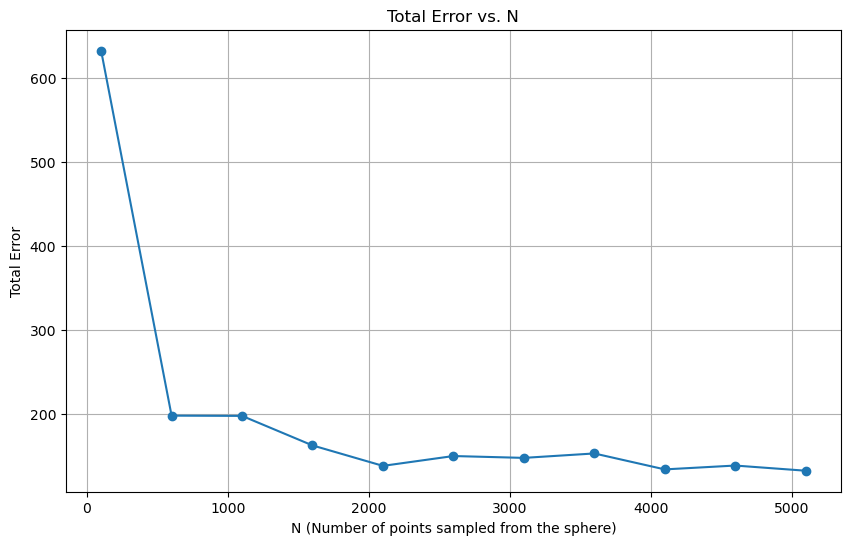

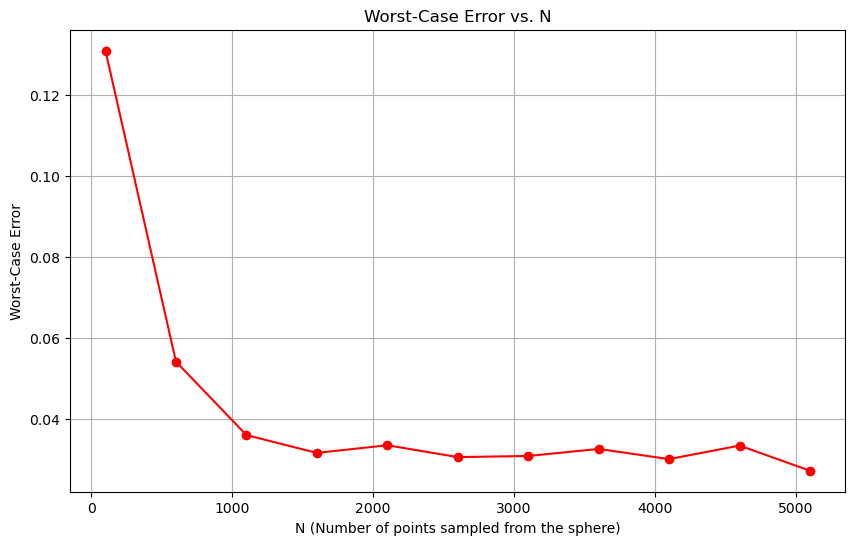

In [6]:
# Define the function to calculate total error between actual and approximate kernels
def calculate_total_error(X, M, N_values, dimension):
    actual_kernel = gaussian_kernel_matrix(X)
    errors = []

    for N in N_values:
        r = sample_r(M, df=dimension)
        v = sample_v(N, dimension)
        approx_kernel = approximate_kernel(X, X, r, v)
        error = np.sum(np.abs(actual_kernel - approx_kernel))
        errors.append(error)

    return errors

# Define the function to calculate worst-case error between actual and approximate kernels
def calculate_worst_case_error(X, M, N_values, dimension):
    actual_kernel = gaussian_kernel_matrix(X)
    worst_case_errors = []

    for N in N_values:
        r = sample_r(M, df=dimension)
        v = sample_v(N, dimension)
        approx_kernel = approximate_kernel(X, X, r, v)
        error = np.max(np.abs(actual_kernel - approx_kernel))
        worst_case_errors.append(error)

    return worst_case_errors

# Set parameters
dimension = 3
M = 50  # Fixed value for M
N_values = range(100, 5500, 500)  # Range of N values
n_points = 5  # Number of points in each dimension
x1 = np.linspace(0, 5, n_points)
x2 = np.linspace(0, 5, n_points)
x3 = np.linspace(0, 5, n_points)
X = np.array(np.meshgrid(x1, x2, x3)).T.reshape(-1, 3)

# Calculate and plot total error
total_errors = calculate_total_error(X, M, N_values, dimension)
plt.figure(figsize=(10, 6))
plt.plot(list(N_values), total_errors, marker='o')
plt.xlabel('N (Number of points sampled from the sphere)')
plt.ylabel('Total Error')
plt.title('Total Error vs. N')
plt.grid(True)
plt.savefig('ssf_total_error_3d.png')

# Calculate and plot worst-case error
worst_case_errors = calculate_worst_case_error(X, M, N_values, dimension)
plt.figure(figsize=(10, 6))
plt.plot(list(N_values), worst_case_errors, marker='o', color='red')
plt.xlabel('N (Number of points sampled from the sphere)')
plt.ylabel('Worst-Case Error')
plt.title('Worst-Case Error vs. N')
plt.grid(True)
plt.savefig('ssf_worst_case_error_3d.png')